## Gathering BGG Data

This notebook gives the web scraping pipeline to get data for each board game on BGG

In [696]:
import requests, bs4
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import time, os

import matplotlib.pyplot as plt

import statsmodels.api as sm
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy import stats

In [102]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

In [103]:
#url = "https://boardgamegeek.com/boardgame/586/front/stats"

#response = requests.get(url)
#status = response.status_code
#if status == 200:
#  page = response.text
#  soup = bs(page)
#else:
#  print(f"Oops! Received status code {status}")

In [153]:
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

driver = webdriver.Chrome(chromedriver)

<ipython-input-153-3ed8d520c4d8>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(chromedriver)


## Stats Page

We'll begin by exploring the stats page for one game. From here, we should be able to get

* Number owned
* Average rating
* Weight
* Recommended age
* Min, max estimated time
* Min, max player count
* Community min, max and best player counts

Other features to consider:

* \# of ratings
* Std deviation of ratings
* \# of comments
* \# of plays
* \# of fans
* \# of page views
* Prev. owned
* Wishlist

In [105]:

driver.get("https://boardgamegeek.com/boardgame/122691/magnum-opus/stats")

soup = bs(driver.page_source,'html5lib')

In [106]:
soup.find_all(href=re.compile("status=own"))[0].text

'316'

In [107]:
soup.find(text=re.compile("Avg. Rating")).next.next.text.strip()

'6.967'

In [108]:
def get_num_owned(soup):
    try:
        num_str = soup.find(href=re.compile("status=own")).text
        num = int(num_str.replace(",",""))
        return num
    except:
        return None

In [109]:
get_num_owned(soup)

316

In [110]:
def get_rating(soup):
    try:
        return float(soup.find(text=re.compile("Avg. Rating")).next.next.text.strip())
    except:
        return None

In [111]:
get_rating(soup)

6.967

### Gameplay items

The gameplay item class contains 4 relevant pieces of information for us.

* Player count
* Play time
* Player age
* Weight

In [112]:
gameplay_list = soup.find_all(class_="gameplay-item")

print([x.text for x in gameplay_list])

[' \t\t\t\t \t\t\t\t\t     2–4  \t\t\t\t\tPlayers \t\t\t\t \t\t\t\t \t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t\t\tCommunity: \t\t\t\t\t\t\t \t\t\t\t\t\t\t\t(no votes) \t\t\t\t\t\t\t \t\t\t\t\t\t\t \t\t\t\t\t\t\t\t3–4 \t\t\t\t\t\t\t \t\t\t\t\t\t\t \t\t\t\t\t\t\t\t— \t\t\t\t\t\t\t\tBest: 4 \t\t\t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t \t\t\t\t \t\t\t', ' \t\t\t\t \t\t\t\t\t \t\t\t\t\t \t\t\t\t\t\t     60  Min \t\t\t\t\t \t\t\t\t \t\t\t\t \t\t\t\t\t \t\t\t\t\t\tPlaying Time \t\t\t\t\t \t\t\t\t\t \t\t\t\t \t\t\t', ' \t\t\t\t \t\t\t\t\tAge: \t\t\t\t\t \t\t\t\t\t \t\t\t\t\t\t12+ \t\t\t\t\t \t\t\t\t \t\t\t\t \t\t\t\t\t \t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t\t\tCommunity: 12+ \t\t\t\t\t\t \t\t\t\t\t \t\t\t\t \t\t\t', " \t\t\t\t \t\t\t\t\tWeight: \t\t\t\t\t \t\t\t\t\t\t–– \t\t\t\t\t \t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t\t\t2.54 \t\t\t\t\t\t \t\t\t\t\t\t/ 5 Complexity Rating \t\t\t\t\t  \t\t\t\t \t\t\t\t \t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t\t\t'Complexity' Rating Results \t\t\t\t\t\t \t\t\t\t\t  \t\t\t\t\t \t\t\t\t\t\t

Game weight and player age are fairly straight forward

In [113]:
float(gameplay_list[3].find(text=re.compile("/ 5")).previous.strip())

2.54

In [114]:
def get_weight(soup):
    try:
        gameplay_list = soup.find_all(class_="gameplay-item")

        return float(gameplay_list[3].find(text=re.compile("/ 5")).previous.strip())
    
    except:
        return None

In [115]:
get_weight(soup)

2.54

In [116]:
#Fix this, so not dependant on +
def get_age(soup):
    try:
        gameplay_list = soup.find_all(class_="gameplay-item")
        return int(gameplay_list[2].find(text=re.compile("\+")).strip().replace("+",""))
    except:
        return None

In [117]:
x = get_age(soup)

In [118]:
print(x)

12


Note this is only the age "on the box". There is also a community recommended age, which I am not scraping at this time. (Something to look at later)

Play time and player counts are trickier. The way the html is structured changes based on if the minimum and maximum values are the same. For example the player count may appear as 

2 Players

OR

2 - 6 Players

So we have to deal with those cases here.

In [28]:
gameplay_list[1].find_all(class_=re.compile("ng-binding ng-scope"))

[<span class="ng-binding ng-scope" ng-if="min &gt; 0">60</span>]

In [267]:
def get_minmax_time(soup):
    try:
        gameplay_list = soup.find_all(class_="gameplay-item")
        time_values = gameplay_list[1].find_all(class_=re.compile("ng-binding ng-scope"))
        if len(time_values) == 3:
            return int(time_values[0].text), int(time_values[1].text.replace("–",""))
        else:
            #If only one value, same min and max time
            value = int(time_values[0].text)
            return value,value
    except:
        return None, None

In [30]:
get_minmax_time(soup)

(60, 60)

In [31]:
gameplay_list[0].find_all(class_=re.compile("ng-binding ng-scope"))

[<span class="ng-binding ng-scope" ng-if="min &gt; 0">2</span>,
 <span class="ng-binding ng-scope" ng-if="max&gt;0 &amp;&amp; min != max"><!-- ngIf: min>0 --><span class="ng-binding ng-scope" ng-if="min&gt;0">–</span><!-- end ngIf: min>0 -->3</span>,
 <span class="ng-binding ng-scope" ng-if="min&gt;0">–</span>]

In [268]:
def get_minmax_players(soup):
    try:
        gameplay_list = soup.find_all(class_="gameplay-item")
        players_values = gameplay_list[0].find_all(class_=re.compile("ng-binding ng-scope"))
        if len(players_values) == 3:
            return int(players_values[0].text), int(players_values[1].text.replace("–",""))
        else:
            #If only one player count, min and max are the same
            value = int(players_values[0].text)
            return value, value
    except:
        return None, None
    


In [33]:
get_minmax_players(soup)

(2, 3)

There is also community recommended number of players (a min, max and best count). This is again something to look at later.

## Credits Page

Like we did for the stats page, we'll now try to collect the data for one credits page. Features we are looking to scrape are:

* Designer(s)
* Publisher(s)
* Categories
* Mechanisms

The should all be fairly similar, but note that each of these may have more than one entry. A slight challenge to account for.

In [92]:

driver.get("https://boardgamegeek.com/boardgame/122691/magnum-opus/credits")

soup = bs(driver.page_source,'html5lib')

In [93]:
def get_publishers(soup):
    try:
        pubs = soup.find(attrs={"name":"boardgamepublisher"}).find_next("div").find_all("a")
        pubs = [x.text.strip() for x in pubs]
        return pubs
    except:
        return None


In [94]:
get_publishers(soup)

['Clever Mojo Games', 'Game Salute']

In [95]:
def get_designers(soup):
    try:
        designers = soup.find(attrs={"name":"boardgamedesigner"}).find_next("div").find_all("a")
        designers = [x.text.strip() for x in designers]
        return designers
    except:
        return None

In [96]:
get_designers(soup)

['Ian Stedman']

In [97]:
def get_categories(soup):
    try:
        cats = soup.find(attrs={"name":"boardgamecategory"}).find_next("div").find_all("a")
        cats = [x.text.strip() for x in cats]
        return cats
    except:
        return None

In [98]:
get_categories(soup)

['Card Game', 'Fantasy', 'Medieval', 'Mythology']

In [242]:
def get_mechanics(soup):
    try:
        mechs = soup.find(attrs={"name":"boardgamemechanic"}).find_next("div").find_all("a")
        mechs = [x.text.strip() for x in mechs]
        return mechs
    except:
        return None

In [244]:
get_mechanics(soup)

## URL Collections

Now let's collect the name, url, and year for all the games.

We'll start by creating an empty dataframe to fill in with the information as we get it.

In [177]:
column_names = ["name","url","year", "num_owned", "rating", "weight", "player_age", "min_players","max_players",
               "min_time","max_time","designers","publishers","categories","mechanics"]

df = pd.DataFrame(columns = column_names)

df

,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics


In [178]:
import time

base_url = "https://boardgamegeek.com/browse/boardgame/page/"
start = 1
stop = 214

for i in range(start, stop+1):
    if  (i - start) % 10 == 2:
        print((i-start)/(stop-start)*100, "% pages read,", (i-start), "in total")
        df.to_csv("games.csv", index=False)
    url = base_url + str(i)
    driver.get(url)
    soup = bs(driver.page_source,'html5lib')
    rows = []
    for x in soup.find_all("div", attrs={"id":re.compile("results_objectname")}):
        try:
            game_url = x.find("a")["href"]
        except:
            game_url = None
        try:
            game_name = x.find("a").text
        except:
            game_name = None
        try:
            game_year = int(x.find(class_="smallerfont dull").text.replace("(","").replace(")",""))
        except:
            game_year = None
        rows.append([game_name,game_url, game_year])
    df_temp = pd.DataFrame(rows, columns = ["name","url","year"])
    df = pd.concat([df,df_temp])
    time.sleep(5)

df.to_csv("games.csv", index=False)

0.9389671361502347 % pages read, 2 in total
5.633802816901409 % pages read, 12 in total
10.328638497652582 % pages read, 22 in total
15.023474178403756 % pages read, 32 in total
19.718309859154928 % pages read, 42 in total
24.413145539906104 % pages read, 52 in total
29.107981220657276 % pages read, 62 in total
33.80281690140845 % pages read, 72 in total
38.497652582159624 % pages read, 82 in total
43.1924882629108 % pages read, 92 in total
47.88732394366197 % pages read, 102 in total
52.58215962441315 % pages read, 112 in total
57.27699530516433 % pages read, 122 in total
61.97183098591549 % pages read, 132 in total
66.66666666666666 % pages read, 142 in total
71.36150234741784 % pages read, 152 in total
76.05633802816901 % pages read, 162 in total
80.75117370892019 % pages read, 172 in total
85.44600938967136 % pages read, 182 in total
90.14084507042254 % pages read, 192 in total
94.83568075117371 % pages read, 202 in total
99.53051643192488 % pages read, 212 in total


,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics
0,Gloomhaven,/boardgame/174430/gloomhaven,2017,None,None,None,None,None,None,None,None,None,None,None,None
1,Pandemic Legacy: Season 1,/boardgame/161936/pandemic-legacy-season-1,2015,None,None,None,None,None,None,None,None,None,None,None,None
2,Brass: Birmingham,/boardgame/224517/brass-birmingham,2018,None,None,None,None,None,None,None,None,None,None,None,None
3,Terraforming Mars,/boardgame/167791/terraforming-mars,2016,None,None,None,None,None,None,None,None,None,None,None,None
4,Gloomhaven: Jaws of the Lion,/boardgame/291457/gloomhaven-jaws-lion,2020,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Labyrinth,/boardgame/6546/labyrinth,1940.0,None,None,None,None,None,None,None,None,None,None,None,None
96,Dirty Minds: The Game of Naughty Clues,/boardgame/2956/dirty-minds-game-naughty-clues,1990.0,None,None,None,None,None,None,None,None,None,None,None,None
97,MindTrap,/boardgame/1923/mindtrap,1991.0,None,None,None,None,None,None,None,None,None,None,None,None
98,Phase 10,/boardgame/1258/phase-10,1982.0,None,None,None,None,None,None,None,None,None,None,None,None


In [246]:
df2 = df.sample(frac=1)
df2.reset_index(inplace=True,drop=True)
df2.head()

,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics
0,The Piggyback Brigade,/boardgame/1806/piggyback-brigade,2000,None,None,None,None,None,None,None,None,None,None,None,None
1,Skräll,/boardgame/31421/skrall,2007.0,None,None,None,None,None,None,None,None,None,None,None,None
2,Descent on Crete: May 1941,/boardgame/5860/descent-crete-may-1941,1978.0,None,None,None,None,None,None,None,None,None,None,None,None
3,Castro,/boardgame/149863/castro,2013,None,None,None,None,None,None,None,None,None,None,None,None
4,1655: Habemus Papam,/boardgame/82955/1655-habemus-papam,2010,None,None,None,None,None,None,None,None,None,None,None,None


df.dtypes

Now let's scrape all the pages

In [536]:
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

driver = webdriver.Chrome(chromedriver)

for ind in df2.index:
    #Check if we've seen this row already
    if df2.iloc[ind].notna().sum() > 3:
        continue
        
    
    if ind % 20 == 0:
        print(ind, "games scraped", ind/df2.shape[0]*100, "%")
        df2.to_csv("games2.csv", index=False)
        
        
    url = "https://boardgamegeek.com/" + df2.iloc[ind].url
    
    driver.get(url + "/stats")
    stats_soup = bs(driver.page_source,'html5lib')
    
    df2.iloc[ind].num_owned = get_num_owned(stats_soup)
    df2.iloc[ind].rating = get_rating(stats_soup)
    df2.iloc[ind].weight = get_weight(stats_soup)
    df2.iloc[ind].player_age = get_age(stats_soup)
    df2.iloc[ind].min_time,df2.iloc[ind].max_time= get_minmax_time(stats_soup)
    df2.iloc[ind].min_players,df2.iloc[ind].max_players= get_minmax_players(stats_soup)
    
    time.sleep(5)
    
    driver.get(url + "/credits")
    credits_soup = bs(driver.page_source,'html5lib')
    
    df2.iloc[ind].designers = get_designers(credits_soup)
    df2.iloc[ind].publishers = get_publishers(credits_soup)
    df2.iloc[ind].categories = get_categories(credits_soup)
    df2.iloc[ind].mechanics = get_mechanics(credits_soup)
    
    
    
    time.sleep(5)
    
    
    

<ipython-input-536-456363c97cd4>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(chromedriver)


15880 games scraped 74.20560747663552 %
15900 games scraped 74.29906542056075 %
15920 games scraped 74.39252336448598 %
15940 games scraped 74.48598130841123 %
15960 games scraped 74.57943925233644 %
15980 games scraped 74.67289719626167 %
16000 games scraped 74.76635514018692 %
16020 games scraped 74.85981308411215 %
16040 games scraped 74.95327102803738 %
16060 games scraped 75.04672897196262 %
16080 games scraped 75.14018691588785 %
16100 games scraped 75.23364485981308 %
16120 games scraped 75.32710280373833 %
16140 games scraped 75.42056074766356 %
16160 games scraped 75.51401869158877 %
16180 games scraped 75.60747663551402 %
16200 games scraped 75.70093457943925 %
16220 games scraped 75.79439252336448 %
16240 games scraped 75.88785046728972 %
16260 games scraped 75.98130841121495 %
16280 games scraped 76.07476635514018 %
16300 games scraped 76.16822429906543 %
16320 games scraped 76.26168224299066 %
16340 games scraped 76.35514018691589 %
16360 games scraped 76.44859813084112 %


20020 games scraped 93.55140186915888 %
20040 games scraped 93.64485981308411 %
20060 games scraped 93.73831775700936 %
20080 games scraped 93.83177570093459 %
20100 games scraped 93.92523364485982 %
20120 games scraped 94.01869158878505 %
20140 games scraped 94.11214953271028 %
20160 games scraped 94.2056074766355 %
20180 games scraped 94.29906542056075 %
20200 games scraped 94.39252336448598 %
20220 games scraped 94.48598130841121 %
20240 games scraped 94.57943925233646 %
20260 games scraped 94.67289719626169 %
20280 games scraped 94.76635514018692 %
20300 games scraped 94.85981308411215 %
20320 games scraped 94.95327102803738 %
20340 games scraped 95.04672897196261 %
20360 games scraped 95.14018691588785 %
20380 games scraped 95.23364485981308 %
20400 games scraped 95.32710280373831 %
20420 games scraped 95.42056074766356 %
20440 games scraped 95.51401869158879 %
20460 games scraped 95.60747663551402 %
20480 games scraped 95.70093457943926 %
20500 games scraped 95.7943925233645 %
20

In [541]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21400 entries, 0 to 21399
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         21400 non-null  object
 1   url          21400 non-null  object
 2   year         21216 non-null  object
 3   num_owned    21399 non-null  object
 4   rating       21397 non-null  object
 5   weight       21399 non-null  object
 6   player_age   20971 non-null  object
 7   min_players  21365 non-null  object
 8   max_players  21365 non-null  object
 9   min_time     20783 non-null  object
 10  max_time     20783 non-null  object
 11  designers    21390 non-null  object
 12  publishers   21390 non-null  object
 13  categories   21390 non-null  object
 14  mechanics    21390 non-null  object
dtypes: object(15)
memory usage: 2.4+ MB


In [716]:

game_df = df2[df2.num_owned.notna()]

In [717]:
game_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21399 entries, 0 to 21399
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         21399 non-null  object
 1   url          21399 non-null  object
 2   year         21215 non-null  object
 3   num_owned    21399 non-null  object
 4   rating       21397 non-null  object
 5   weight       21399 non-null  object
 6   player_age   20971 non-null  object
 7   min_players  21365 non-null  object
 8   max_players  21365 non-null  object
 9   min_time     20783 non-null  object
 10  max_time     20783 non-null  object
 11  designers    21389 non-null  object
 12  publishers   21389 non-null  object
 13  categories   21389 non-null  object
 14  mechanics    21389 non-null  object
dtypes: object(15)
memory usage: 2.6+ MB


In [718]:
game_df.loc[:,"num_owned"] = game_df.num_owned.astype(int, errors="ignore")

/Users/rsolava/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [719]:
game_df.loc[:,"rating"] = game_df.rating.astype(float, errors="ignore")
game_df.loc[:,"year"] = game_df.year.astype(float,errors="ignore")
game_df.loc[:,"weight"] = game_df.weight.astype(float, errors="ignore")
game_df.loc[:,"player_age"] = game_df.player_age.astype(float, errors="ignore")
game_df.loc[:,"min_players"] = game_df.min_players.astype(float, errors="ignore")
game_df.loc[:,"max_players"] = game_df.max_players.astype(float, errors="ignore")
game_df.loc[:,"min_time"] = game_df.min_time.astype(float, errors="ignore")
game_df.loc[:,"max_time"] = game_df.max_time.astype(float, errors="ignore")

/Users/rsolava/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [720]:
game_df.dtypes

name            object
url             object
year           float64
num_owned        int64
rating         float64
weight         float64
player_age     float64
min_players    float64
max_players    float64
min_time       float64
max_time       float64
designers       object
publishers      object
categories      object
mechanics       object
dtype: object

In [562]:
game_df["log_owned"] = np.log(game_df.num_owned)

Remove outliers

In [732]:

game_df = game_df[~((game_df.log_owned < (Q1 - 1.5 * IQR)) |(game_df.log_owned > (Q3 + 1.5 * IQR)))]


<ipython-input-732-6e8bbde5d9bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df["log_owned"] = np.log(game_df.num_owned)


In [733]:
game_df.shape

(20988, 16)

In [741]:
game_df = game_df.dropna()
game_df.shape

(19860, 16)

In [801]:
X =game_df.drop(columns =["name","url","num_owned","designers","publishers","categories","mechanics","log_owned"])
X["weight_sq"] = X.weight*X.weight
X = X.drop(columns="weight")
X["avg_time"] = (X.min_time + X.max_time)/2
X = X.drop(columns=["min_time","max_time"])
X["avg_players"] = (X.min_players + X.max_players)/2
X = X.drop(columns=["min_players","max_players"])
y = game_df.num_owned
X = sm.add_constant(X)

model = sm.OLS(np.log(y),X)
game_model = model.fit()

game_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_owned   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     283.3
Date:                Thu, 04 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:14:32   Log-Likelihood:                -31882.
No. Observations:               19860   AIC:                         6.378e+04
Df Residuals:                   19853   BIC:                         6.383e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.1527      0.215     19.348      0.000       3.732       4.573
year           -0.0002      0.000     -2.278      0.023      -0.000   -3.33e-05
rating          0.2880      0.011     26.351      0.000       0.267       0.309
player_age      0.0341      0.004      9.731      0.000       0.027       0.041
weight_sq       0.0216      0.003      7.536      0.000       0.016       0.027
avg_time    -3.927e-05   1.83e-05     -2.140      0.032   -7.52e-05    -3.3e-06
avg_players     0.0009      0.001      0.832      0.405      -0.001       0.003
==============================================================================
Omnibus:                      418.103   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              440.545
Skew:                           0.359   Prob(JB):                     2.17e-96
Kurtosis:                       2.865   Cond. No.                     5.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

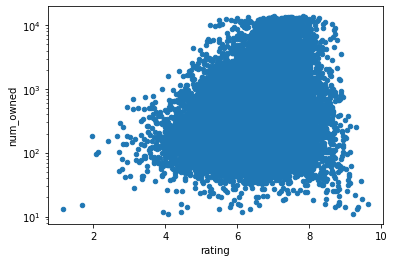

In [748]:
x = np.arange(0, 6)

# scatter-plot data
ax = game_df.plot(x='rating', y='num_owned', kind='scatter',logy=True)

# plot regression line on the same axes, set x-axis limits
#ax.plot(x, np.exp(game_model.params.const + game_model.params.weight * x), color = "red")

#plt.savefig("weight_reg.png", bbox_inches="tight")

In [749]:
game_model.params

const          4.110051
year          -0.000199
rating         0.263489
weight         0.171679
player_age     0.025420
min_players   -0.014926
max_players    0.000924
min_time       0.000043
max_time      -0.000079
dtype: float64

In [553]:
game_df = game_df.dropna()
game_df.shape

(20266, 15)

In [755]:
y = game_df.num_owned
X = game_df.drop(columns =["name","url","rating","num_owned","designers","publishers","categories","mechanics","log_owned"])

X, X_test, y, y_test = train_test_split(X,y, test_size=0.3)

reg_tree = RandomForestRegressor(max_depth=25)
reg_tree.fit(X, np.log(y))


RandomForestRegressor(max_depth=25)

In [756]:
reg_tree.feature_importances_

array([0.19803491, 0.40250388, 0.09411064, 0.04093385, 0.08670005,
       0.08162891, 0.09608775])

In [757]:
reg_tree.score(X_test,np.log(y_test))

0.30798540408679365

In [758]:
game_df.head()

,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics,log_owned
0,The Piggyback Brigade,/boardgame/1806/piggyback-brigade,2000.0,679,6.101,1.05,4.0,2.0,7.0,15.0,25.0,[Alex Randolph],"[Devir, Drei Magier Spiele, G3, Korea Boardgam...","[Action / Dexterity, Children's Game, Dice, Ra...",[Dice Rolling],6.520621
2,Descent on Crete: May 1941,/boardgame/5860/descent-crete-may-1941,1978.0,249,5.961,3.91,14.0,2.0,2.0,240.0,240.0,[Eric Goldberg],"[SPI (Simulations Publications, Inc.)]","[Wargame, World War II]","[Dice Rolling, Hexagon Grid, Simulation]",5.517453
3,Castro,/boardgame/149863/castro,2013.0,287,6.515,1.41,8.0,2.0,4.0,20.0,20.0,[Jürgen P. Grunau],[Noris Spiele],[Dice],"[Dice Rolling, Pattern Building, Push Your Luck]",5.659482
4,1655: Habemus Papam,/boardgame/82955/1655-habemus-papam,2010.0,738,6.453,2.16,10.0,3.0,4.0,30.0,30.0,[Christoph Bauer],"[999 Games, DDD Verlag GmbH]","[Card Game, Pike and Shot, Religious]","[Auction/Bidding, Set Collection]",6.603944
5,Kreus,/boardgame/198110/kreus,2016.0,826,6.696,2.00,10.0,3.0,6.0,20.0,30.0,[Julien Prothière],"[2Tomatoes Games, CMON Global Limited, Sweet G...","[Card Game, Deduction, Mythology]","[Communication Limits, Cooperative Game]",6.716595


## Are games sold and number owned correlated?

We're using number of users who own the game as a proxy for number of games sold, since unfortunately the number of games sold is just not public information. It seems reasonable that these things would be correlated, but are they really? Luckily, one publisher did share their sales data, so we'll use this limited information to see if this assumption is correct.

In [632]:
num_sold = [["Twilight Struggle", 100000], ["Battle Line",40000],["Dominant Species",25000],
            ["Commands & Colors: Ancients", 20000],["Paths of Glory",16000],["Combat Commander: Europe",13000],
            ["Wilderness War",11000], ["Labyrinth: The War on Terror, 2001 – ?",11000],
            ["Thunder Alley", 9500], ["Formula Motor Racing",9000], ["Ivanhoe",9000],
            ["Commands & Colors: Napoleonics",9000], ["Washington's War", 9000],["Here I Stand", 8500]]

num_sold_df = pd.DataFrame(num_sold, columns = ["name","num_sold"])

In [626]:
game_df[(game_df.name == "Washington's War")]

,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics
15694,Washington's War,/boardgame/38996/washingtons-war,2010.0,4499,7.636,2.84,12.0,2.0,2.0,90.0,90.0,[Mark Herman],"[GMT Games, Spielworxx]","[Age of Reason, American Revolutionary War, Wa...","[Area Majority / Influence, Campaign / Battle ..."


In [642]:
gt_df = num_sold_df.set_index("name").join(game_df.set_index("name"))

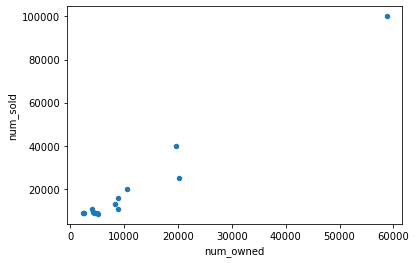

In [650]:

ax = gt_df.plot(x='num_owned', y='num_sold', kind='scatter')

In [646]:
y = gt_df.num_sold
X = gt_df.num_owned
X = sm.add_constant(X)

model = sm.OLS(gt_df.num_sold,gt_df.num_owned)
game_model = model.fit()

game_model.summary()

/Users/rsolava/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               num_sold   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     444.3
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           7.55e-11
Time:                        06:57:09   Log-Likelihood:                -135.34
No. Observations:                  14   AIC:                             274.7
Df Residuals:                      12   BIC:                             276.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1589.9024   1428.204      1.113      0.287   -1521.886    4701.691
num_owned      1.6422      0.078     21.078      0.000       1.472       1.812
==============================================================================
Omnibus:                        5.015   Durbin-Watson:                   2.434
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                2.290
Skew:                          -0.913   Prob(JB):                        0.318
Kurtosis:                       3.771   Cond. No.                     2.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [647]:
gt_df.num_owned.corr(gt_df.num_sold)

0.986762754618917

There is a strong linear relationship between games sold and games owned for this publisher. That's very promising for our analysis, although it may not hold as strongly for all games. It is a very small sample and not representative.

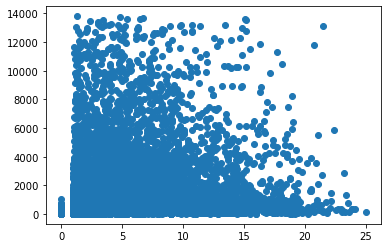

In [736]:
ax = plt.scatter(game_df.weight*game_df.weight,game_df.num_owned)

In [798]:
game_df.num_owned.corr(game_df.weight*game_df.weight)

0.13685204157256672

<AxesSubplot:xlabel='num_owned', ylabel='Count'>

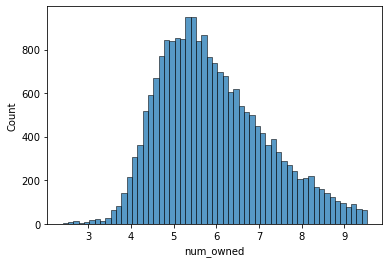

In [738]:
import seaborn as sns
sns.histplot(x=np.log(game_df["num_owned"]))

<AxesSubplot:xlabel='num_owned', ylabel='Count'>

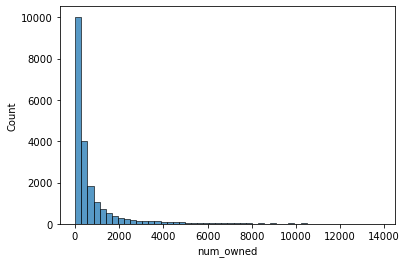

In [734]:
sns.histplot(x=game_df["num_owned"],bins=50)

<AxesSubplot:xlabel='num_owned'>

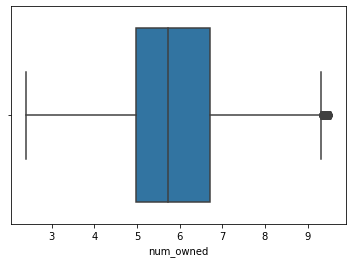

In [735]:

sns.boxplot(x=np.log(game_df["num_owned"]))

In [ ]:
all_publishers = set(game_df.publishers.sum())
all_categories = set(game_df.categories.sum())
all_mechanics = set(game_df.mechanics.sum())
all_designers = set(game_df.designers.sum())


In [ ]:
print("{num} different publishers.".format(len(all_publishers)))

In [705]:
x

{'Charles E. Tuttle Co.',
 'Casper',
 'Gibsons',
 'Eesti päevaleht',
 'Lex Games',
 'Jonathan Pac Cantin Games',
 'Cranium, Inc.',
 'GAMEARChive',
 'Stupendous Games',
 'Wheeler Games (Board Game)',
 'Privateer Press',
 'Regev Games',
 'The United States Playing Card Company',
 'Conclave Editora',
 'Windy Ways Games Pty Ltd',
 'Dos Reis',
 '17wanzy (Yihu BG)',
 'Sunset Games',
 'PICAM (Products International Company Advertising/Marketing)',
 "OPEN'N PLAY",
 'Asobition (アソビション)',
 'B&R Mindworks',
 'Totally Insane Card Game Company',
 'Shoptaugh Games',
 'Magma Éditions',
 'John W. Hill & Co.',
 '桌遊鬍子 POKI Design',
 'Unsolved Case Files',
 'Cephalofair Games',
 'Edukit S.A',
 'Spielcraft Games',
 'Tuber Productions',
 'The Great American Greed Company',
 'L. J. Hjerta',
 'Cafe Games',
 'Palabra Enterprises',
 'Maruca Industries',
 'Tortugames',
 'Six to Start',
 'Waterfall Games',
 'Fresno Gaming Association',
 'Platypus Industries',
 'Imbalanced Games LLC',
 'Nick Pace Entertainment',


In [709]:
Q1 = np.log(game_df.num_owned).quantile(0.25)
Q3 = np.log(game_df.num_owned).quantile(0.75)
IQR = Q3 - Q1
print(IQR)

1.7938939417566875


In [712]:
log_owned = np.log(game_df.num_owned)

In [715]:
sum((log_owned < (Q1 - 1.5 * IQR)) |(log_owned > (Q3 + 1.5 * IQR)))

406

In [793]:
game_df.sort_values(by="year").groupby(by="year").num_owned.mean().idxmax()
#sns.barplot(x=y.index,y=y)

1630.0

In [794]:
game_df[game_df.year==1630]

,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics,log_owned
3380,Cribbage,/boardgame/2398/cribbage,1630.0,13154,7.063,1.9,10.0,2.0,4.0,30.0,30.0,[Sir John Suckling],"[(Public Domain), (Unknown), 5th Peg, Acme Rul...",[Card Game],[Hand Management],9.484481
